Singlife has observed a concerning trend in the customer journey: potential policyholders are expressing hesitation and eventual disengagement during the insurance acquisition process. To address this, Singlife seeks to leverage its dataset. The objective is to derive actionable insights from this data to enhance the customer experience. The challenge is to dissect the dataset to uncover the critical touchpoints that contribute to customer drop-off (people who choose not to renew to active) and identify opportunities to streamline the application process and personalise communication. The ultimate goal is to predict customer satisfaction and conversion rates, thereby bolstering Singlife's market position.

In [ ]:
#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install seaborn
#%pip install scikit-learn
#%pip install imbalanced-learn
#%pip install xgboost
#%pip install lightgbm
#%pip install tensorflow
#%pip install keras

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Metrics
import sklearn.metrics as metrics

2024-01-29 15:24:20.676407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 15:24:21.057368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-29 15:24:21.057425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-29 15:24:21.096010: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 15:24:23.152785: W tensorflow/stream_executor/platform/de

In [ ]:
filepath = "./data/datathon.parquet" 
data = filepath

In [2]:
# load dataset
#data = pd.read_parquet('catB_train.parquet')
#data

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,3363260248,None,Singapore,P,LAPSED,2016-08-01,1994-05-24,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
11964,c3509f0aef,Chinese,Singapore,P,ACTIVE,1990-03-20,1948-12-16,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
5390,6e44cfb3e7,Chinese,Singapore,P,ACTIVE,2007-12-31,1967-12-06,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
860,dd4e362f9f,Others,Singapore,P,ACTIVE,2007-09-01,1986-04-01,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


## Splitting Dataset

In [3]:
# Focus on Singapore specific data
data = data[data['ctrycode_desc'] == 'Singapore']

# Clean target column
def data_cleaning(data): 
    data.f_purchase_lh.unique() # only contains nan and 1
    data['f_purchase_lh'] = data['f_purchase_lh'].fillna(0) # replace NAN in target with 0
    return data

data = data_cleaning(data)

# Create features (X) by dropping the target variable
X = data.drop('f_purchase_lh', axis=1)

# Create the target variable (y)
y = data['f_purchase_lh']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

/tmp/ipykernel_1199/1640289494.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['f_purchase_lh'] = data['f_purchase_lh'].fillna(0) # replace NAN in target with 0
X_train shape: (14231, 303)
X_test shape: (3558, 303)
y_train shape: (14231,)
y_test shape: (3558,)


## Data Cleaning

In [4]:
# Drop columns with all NaN values from both the train and test sets
X_train = X_train.dropna(axis=1, how='all').copy()
X_test = X_test.dropna(axis=1, how='all').copy()

In [5]:
# Check if there are duplicated client ids
print("Number of Duplicated Client IDs in X_train:", X_train.clntnum.duplicated().sum())  # all client ids are unique in X_train
print("Number of Duplicated Client IDs in X_test:", X_test.clntnum.duplicated().sum())    # all client ids are unique in X_test

# Drop the 'clntnum' column
X_train.drop('clntnum', axis=1, inplace=True)
X_test.drop('clntnum', axis=1, inplace=True)

Number of Duplicated Client IDs in X_train: 0
Number of Duplicated Client IDs in X_test: 0


In [6]:
columns_to_delete = list(range(40, 271))  # Columns 40 to 271
X_train = X_train.drop(X_train.columns[columns_to_delete], axis=1)
X_test =  X_test.drop(X_test.columns[columns_to_delete], axis=1) 

# Display the shape of the resulting DataFrame
print("X_train shape after deleting columns:", X_train.shape)
print("X_test shape after deleting columns:", X_test.shape)

X_train shape after deleting columns: (14231, 63)
X_test shape after deleting columns: (3558, 63)


In [7]:
# Drop columns with zero variance 

# Select the columns with zero variance first in X_train then drop the same columns from X_test to maintain same number of columns
numeric_columns = X_train.select_dtypes(include=np.number).columns
string_columns = X_train.select_dtypes(include='object').columns

# Select numeric columns with zero variance
zero_variance_numeric = X_train[numeric_columns].columns[X_train[numeric_columns].apply(lambda col: col.var() == 0)]

# Select string columns with zero variance
zero_variance_string = X_train[string_columns].columns[X_train[string_columns].apply(lambda col: col.nunique() == 1)]

# Drop columns for X_train and X_test
columns_to_drop = zero_variance_numeric.append(zero_variance_string)
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [8]:
# Drop columns with high percentage of missing values (Missing Value Ratio)
# Calculate the missing value ratio for each column
missing_ratio = X_train.isnull().mean()

# Set a threshold for the missing value ratio
threshold = 0.8

# Identify columns with missing value ratio above the threshold
columns_to_drop = missing_ratio[missing_ratio > threshold].index

# Drop columns with high missing value ratio
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

# Display information about the dropped columns
print(f"columns with missing value ratio above {threshold}:", columns_to_drop)
print("Shape of X_train after dropping columns:", X_train.shape)
print("Shape of X_test after dropping columns:", X_test.shape)

columns with missing value ratio above 0.8: Index(['recency_cancel', 'tot_cancel_pols', 'flg_affconnect_lapse_ever',
       'affcon_visit_days', 'n_months_since_visit_affcon', 'clmcon_visit_days',
       'recency_clmcon', 'recency_clmcon_regis', 'hlthclaim_amt',
       'recency_hlthclaim', 'hlthclaim_cnt_success',
       'recency_hlthclaim_success', 'hlthclaim_cnt_unsuccess',
       'recency_hlthclaim_unsuccess', 'recency_hlthclaim_839f8a',
       'recency_hlthclaim_14cb37', 'giclaim_amt', 'recency_giclaim'],
      dtype='object')
Shape of X_train after dropping columns: (14231, 38)
Shape of X_test after dropping columns: (3558, 38)


In [9]:
# Create additional variable (age)

def add_age(df):
    # create new column with only year/None
    df['cltdob_fix'] = df['cltdob_fix'].astype(str)
    df['yearborn'] = df['cltdob_fix'].str.slice(0,4) # extract year/'None'

    # replace None with mode of year
    mode_value = df['yearborn'].mode().iloc[0]
    df['yearborn'] = df['yearborn'].replace('None', mode_value)
    df['yearborn'] = df['yearborn'].astype(int)

    df['min_occ_date'] = pd.to_datetime(df['min_occ_date'], errors = 'coerce')

    # find age of client
    today = datetime.today()
    year = today.year
    df['age']= df['yearborn'].apply(lambda x: year-x)


    #changing min_occ_date to just year, replace None with mode
    # Extract year from min_occ_date
    df['min_occ_year'] = df['min_occ_date'].dt.year

    # Replace 'NaT' with mode for min_occ_year
    mode_value = df['min_occ_year'].mode().iloc[0]
    df['min_occ_year'] = df['min_occ_year'].fillna(mode_value).astype(int)


    #drop dob,yearborn and min_occ_date columns
    df = df.drop(columns=['cltdob_fix','yearborn','min_occ_date'])

    return df

X_train = add_age(X_train)
X_test = add_age(X_test)

In [10]:
missing_percentage = (X_train.isnull().mean() * 100).round(2)
columns_with_missing_values = missing_percentage[missing_percentage > 0].to_frame() 
columns_with_missing_values

,0
race_desc,22.16
cltsex_fix,0.12
flg_substandard,5.67
flg_is_borderline_standard,5.67
flg_is_revised_term,5.67
flg_is_rental_flat,5.67
flg_has_health_claim,5.67
flg_has_life_claim,5.67
flg_gi_claim,5.67
flg_is_proposal,5.67


In [11]:
# Profile missing race data
filtered_X_train = X_train[X_train['race_desc'].isna()]

filtered_X_train_2 = X_train[X_train['race_desc'] == 'Others']

# Replace missing race_desc values in rows where clttype = 'P' with mode_race_desc and remaining rows (clttype = 'B' or 'C') with 'Mixed'
X_train['race_desc'] = X_train.apply(lambda row: 'Others' if pd.isnull(row['race_desc']) and row['clttype'] == 'P' else ('Mixed' if pd.isnull(row['race_desc']) and row['clttype'] in ['G', 'C'] else row['race_desc']), axis=1)
X_test['race_desc'] = X_test.apply(lambda row: 'Others' if pd.isnull(row['race_desc']) and row['clttype'] == 'P' else ('Mixed' if pd.isnull(row['race_desc']) and row['clttype'] in ['G', 'C'] else row['race_desc']), axis=1)

In [12]:
# Replace na values in binary variable with mode

def replace_na_binary(df):
    # Find binary columns (starting with 'flg' or 'is')
    binary_columns = [col for col in df.columns if col.startswith('flg') or col.startswith('is')]

    # Replace NA values in binary columns with mode
    for col in binary_columns:
        mode_value = df[col].mode().iloc[0]  # Calculate mode
        df[col] = df[col].fillna(mode_value)  # Replace NA values with mode

    return df

X_train = replace_na_binary(X_train)
X_test = replace_na_binary(X_test)

In [13]:
# Replace na values in cltsex_fix with "Unknown"
X_train['cltsex_fix'] = X_train['cltsex_fix'].fillna('Unknown')
X_test['cltsex_fix'] = X_test['cltsex_fix'].fillna('Unknown')

In [14]:
def handle_missing_values(df):

    # Convert 'hh_20', 'pop_20', and 'hh_size_est' columns to numeric
    df['hh_20'] = pd.to_numeric(df['hh_20'], errors='coerce')
    df['pop_20'] = pd.to_numeric(df['pop_20'], errors='coerce')
    df['hh_size_est'] = pd.to_numeric(df['hh_size_est'], errors='coerce')

    # Identify numerical and string columns
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    string_columns = df.select_dtypes(include=['object']).columns
 

    # Calculate percentage of missing values for each column
    missing_percentage_numerical = df[numerical_columns].isnull().mean() * 100 

    
    # Interpolate missing values for numerical columns with less than 20% missing data
    low_missing_numerical_columns = missing_percentage_numerical[(missing_percentage_numerical <= 20)].index.tolist()    
    df[low_missing_numerical_columns] = df[low_missing_numerical_columns].interpolate(method='linear')

    # Replace missing values in numerical columns with more than 20% missing values with mean
    high_missing_numerical_columns = missing_percentage[(missing_percentage > 20) & (df.columns.isin(numerical_columns))].index.tolist()
    df[high_missing_numerical_columns] = df[high_missing_numerical_columns].apply(lambda x: x.fillna(x.mean()))

    # Replace missing values in string columns with mode
    for col in string_columns:
        df[col] = df[col].fillna(df[col].mode().iloc[0])

    # Fill 'hh_size_est' with rounded integer values of 'hh_size' 
    df['hh_size_est'] = df['hh_size'].round().astype('Int64')

    #interpolation does not fill NAs for the 1st and last row of the df
    # Check if the first row has any missing values
    if df.iloc[0].isnull().any():
        # Fill missing values in the first row with column means
        mean_values = df.mean()
        df.iloc[0] = df.iloc[-1].fillna(mean_values)

    # Check if the last row has any missing values
    if df.iloc[-1].isnull().any():
        # Fill missing values in the last row with column means
        mean_values = df.mean()
        df.iloc[-1] = df.iloc[-1].fillna(mean_values)


    return df

X_train = handle_missing_values(X_train)
X_test = handle_missing_values(X_test)

### Split data into Categorical and Numerical data frames

In [15]:
num_columns = ['hh_20', 'pop_20', 'hh_size', 'hh_size_est', 'n_months_last_bought_products', 'recency_lapse', 'tot_inforce_pols','age','min_occ_year']
X_train_num = X_train.loc[:, num_columns]
X_test_num =X_test.loc[:, num_columns]

# Find the columns in X_train that are not in X_train_num which means categorical
columns_to_exclude = X_train.columns.intersection(X_train_num.columns)
columns_to_keep = X_train.columns.difference(columns_to_exclude)

# Create a new DataFrame with columns from X_train not in X_train_num
X_train_cat = X_train[columns_to_keep].copy()
X_test_cat = X_test[columns_to_keep].copy()

## Encoding

In [16]:
def treatNominal(X_train):
    #categorical strings, to edit after cleaning
    nominals = ['race_desc','clttype','stat_flag','cltsex_fix','annual_income_est']
    for nom_col in nominals:
        enc = OneHotEncoder(handle_unknown='ignore')
        categories = pd.unique(X_train[nom_col]).reshape(-1,1)
        enc.fit(categories)

        # Transforming Train Data
        trans_train = enc.transform(np.array(X_train[nom_col]).reshape(-1,1)).todense()
        trans_train = pd.DataFrame(trans_train)
        trans_train.columns = enc.get_feature_names_out([nom_col])
        X_train = pd.concat([X_train.reset_index(drop=True), trans_train],axis=1).drop(nom_col,axis=1)

        # Transforming Test Data
        #trans_test = enc.transform(np.array(X_test[nom_col]).reshape(-1,1)).todense()
        #trans_test = pd.DataFrame(trans_test)
        #trans_test.columns = enc.get_feature_names_out([nom_col])
        #X_test = pd.concat([X_test.reset_index(drop=True), trans_test],axis=1).drop(nom_col,axis=1)
    return (X_train) # returns a tuple

X_train = treatNominal(X_train)
X_test = treatNominal(X_test)

## Standardisation

In [17]:
def standardisation(df):
    df_numeric = df.select_dtypes(include = np.number).columns
    df_scaler = StandardScaler()
    df[df_numeric] = df_scaler.fit_transform(df[df_numeric])
    return df
    
X_train = standardisation(X_train)
X_test = standardisation(X_test)

X_train.head(50) # shape = (14231, 76)

,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,...,stat_flag_LAPSED,stat_flag_MATURED,cltsex_fix_Female,cltsex_fix_Male,cltsex_fix_Unknown,annual_income_est_A.ABOVE200K,annual_income_est_B.100K-200K,annual_income_est_C.60K-100K,annual_income_est_D.30K-60K,annual_income_est_E.BELOW30K
0,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,1.090280,-1.087660,-0.034583,-0.367833,-0.208889,-0.421050,-0.345933,0.848263
1,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,-0.917195,0.919405,-0.034583,-0.367833,-0.208889,-0.421050,2.890734,-1.178879
2,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,-0.917195,0.919405,-0.034583,-0.367833,-0.208889,-0.421050,-0.345933,0.848263
3,-0.197642,5.546677,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,1.090280,-1.087660,-0.034583,-0.367833,-0.208889,-0.421050,-0.345933,0.848263
4,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,1.090280,-1.087660,-0.034583,-0.367833,-0.208889,-0.421050,-0.345933,0.848263
5,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,1.090280,-1.087660,-0.034583,-0.367833,-0.208889,-0.421050,-0.345933,0.848263
6,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,1.090280,-1.087660,-0.034583,-0.367833,-0.208889,-0.421050,-0.345933,0.848263
7,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,7.571246,...,-0.210168,-0.026518,1.090280,-1.087660,-0.034583,-0.367833,-0.208889,-0.421050,-0.345933,0.848263
8,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,-0.917195,0.919405,-0.034583,-0.367833,-0.208889,2.375014,-0.345933,-1.178879
9,-0.197642,-0.180288,-0.027813,-0.107974,-0.222449,-0.05569,-0.179455,-0.053091,-0.091829,-0.132079,...,-0.210168,-0.026518,1.090280,-1.087660,-0.034583,-0.367833,-0.208889,2.375014,-0.345933,-1.178879


## Correlation Matrix

From this, we can tell that there are no variables with high correlation with one another.

In [18]:
correlation_matrix = X_train.corr()

# plt.figure(figsize=(12, 10))

# # Create a heatmap using seaborn
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# plt.show()

# Set a threshold for high correlation (e.g., 0.85)
high_correlation_threshold = 0.85

# Create a mask for identifying highly correlated variables
high_correlation_mask = abs(correlation_matrix) > high_correlation_threshold

# Get the indices where the mask is True
high_correlation_indices = pd.DataFrame(index=correlation_matrix.columns, columns=correlation_matrix.columns)
high_correlation_indices = high_correlation_indices.mask(high_correlation_mask).stack().dropna().index

# Display the pairs of variables that exceed the threshold
print("Variables with High Correlation:")
for index in high_correlation_indices:
    variable1, variable2 = index
    correlation_value = correlation_matrix.loc[variable1, variable2]
    print(f"{variable1} and {variable2}: {correlation_value}")


Variables with High Correlation:


## Dimensionality Reduction (PCA)

In [19]:
# join target column back to training dataset for visualisation. Create another dataset for this
y_train_values = y_train.to_frame()
y_train_values = y_train_values['f_purchase_lh'].to_list()
y_train_values = pd.DataFrame({'f_purchase_lh':y_train_values})
xtrain_pca = pd.concat([X_train, y_train_values], axis = 1)


In [20]:
# PCA for TRAINING Data
# Loop function to identify the number of principal components that explain at least 85% of the variance
for comp in range(1, X_train.shape[1] + 1):  # Start from 1, as having zero components does not make sense
    pca = PCA(n_components=comp, random_state=42)
    pca.fit(X_train)
    comp_check = pca.explained_variance_ratio_
    if comp_check.sum() >= 0.85:
        final_comp = comp
        break

# Transform training data with the selected number of components
final_xtrain_pca = PCA(n_components=final_comp, random_state=42)
xtrain_cluster = pd.DataFrame(final_xtrain_pca.fit_transform(X_train))

# Print information about the selected components
print("Using {} principal components, we can explain {:.2f}% of the variance in the original data.".format(final_comp, comp_check.sum() * 100))

# Subsetting selected features based on PCA results
num_components = 28
selected_pca_components = xtrain_cluster.iloc[:, :num_components]


Using 28 principal components, we can explain 86.00% of the variance in the original data.


In [21]:
# PCA for TESTING Data
# transform standardised testing data using PCA model fitted on training data
xtest_cluster = pd.DataFrame(final_xtrain_pca.transform(X_test))

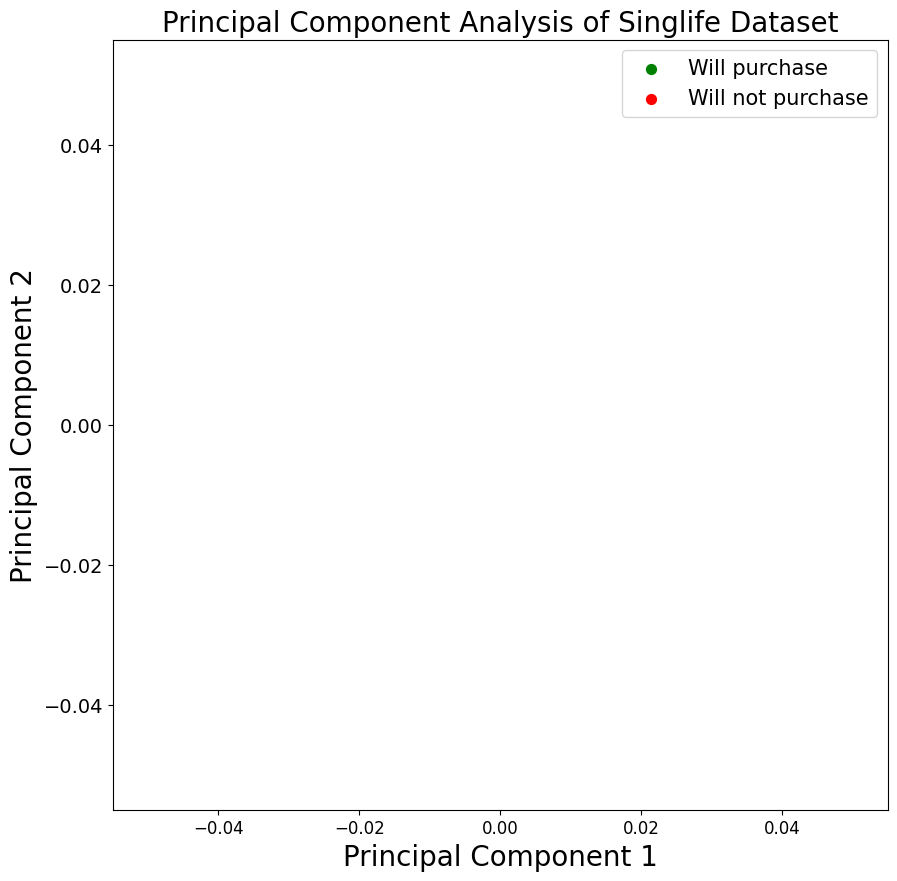

In [22]:
# Convert NumPy array to pandas DataFrame
xtrain_cluster_df = pd.DataFrame(xtrain_cluster, columns=[f'principal component {i+1}' for i in range(final_comp)])

# PCA visualisation
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.title("Principal Component Analysis of Singlife Dataset", fontsize=20)

targets = [1.0,0.0]
labels = ['Will purchase', 'Will not purchase']
colors = ['g', 'r']

for target, color, label in zip(targets, colors, labels):
    indicesToKeep = xtrain_pca['f_purchase_lh'] == target
    plt.scatter(xtrain_cluster_df.loc[indicesToKeep, 'principal component 1'], 
                xtrain_cluster_df.loc[indicesToKeep, 'principal component 2'],
                c=color, s=50)

plt.legend(labels, prop={'size': 15})

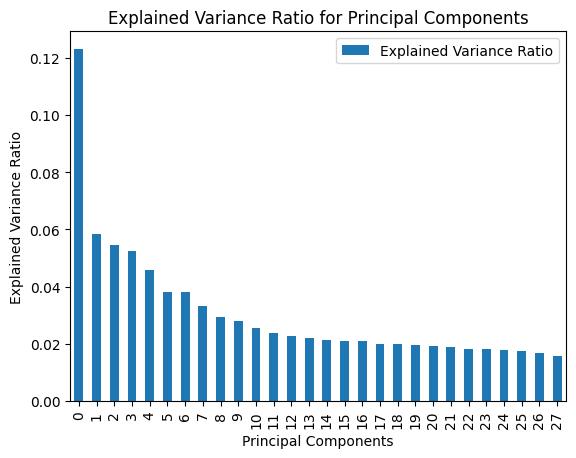

In [23]:
# to see how much variance each PC captures

# Create a DataFrame with explained variance ratio
explained_variance_df = pd.DataFrame(final_xtrain_pca.explained_variance_ratio_, columns=['Explained Variance Ratio'])

# Plot the bar chart
explained_variance_df.plot.bar()
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.show()

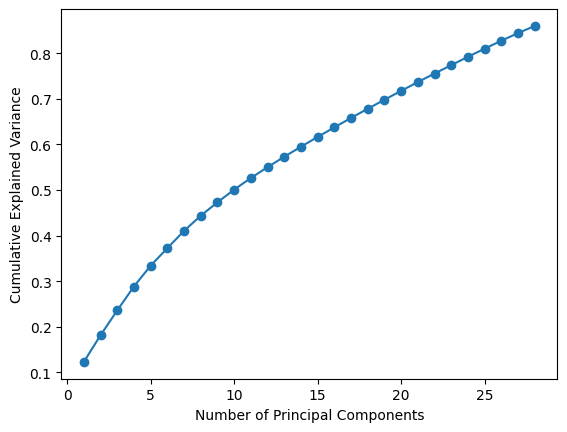

In [24]:
cumulative_explained_variance = final_xtrain_pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, 29), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
# Using elbow method, the reasonable number of principal components is 10.

In [25]:
#identify the 10 most significant features
# Fit PCA with the optimal number of components
optimal_num_components = 10  
pca = PCA(n_components=optimal_num_components)
X_train_pca = pca.fit_transform(X_train)
# Transform the test data using the PCA transformation learned from the training data
X_test_pca = pca.transform(X_test)


# Get the loading vectors (weights) for each principal component
loading_matrix = pd.DataFrame(pca.components_, columns=X_train.columns)

# Display the loading matrix
print("Loading Matrix:")
print(loading_matrix)

# Identify the variables contributing the most to each principal component
top_variables_per_component = loading_matrix.abs().idxmax(axis=1)

# Display the top contributing variables for each principal component
for i in range(optimal_num_components):
    print(f"\nTop variables for Principal Component {i + 1}:")
    print(loading_matrix.iloc[i].abs().nlargest(5))  # Display the top 5 variables


Loading Matrix:
   flg_substandard  flg_is_borderline_standard  flg_is_revised_term  \
0        -0.056363                   -0.057643            -0.008529   
1         0.045204                    0.061390            -0.003411   
2        -0.047039                   -0.074084            -0.012331   
3         0.010362                   -0.015183            -0.015610   
4         0.008319                    0.014714            -0.001432   
5        -0.009446                    0.063382             0.004393   
6         0.041486                   -0.064165             0.003953   
7        -0.040330                   -0.051264             0.005861   
8         0.137645                    0.271174             0.070122   
9         0.109468                    0.372664             0.191053   

   flg_is_rental_flat  flg_has_health_claim  flg_has_life_claim  flg_gi_claim  \
0           -0.015348             -0.068111           -0.015946     -0.035668   
1           -0.082276              0.053

## Feature Selection

### Information Gain (numerical variables)

Information gain calculates the reduction in entropy from the transformation of a dataset. Higher values provide more information about the target variable.

In [26]:
%matplotlib inline

# Perform feature selection for numerical variables using mutual information (information gain)\
num_features_selected = 5  # Number of features to select
selector_numerical = SelectKBest(score_func=mutual_info_classif, k=num_features_selected)
X_train_selected_numerical = selector_numerical.fit_transform(X_train_pca, y_train)
X_test_selected_numerical = selector_numerical.transform(X_test_pca)



In [27]:
# Get the indices of the selected features
selected_feature_indices = selector_numerical.get_support()

# Get the names of the selected features
selected_feature_names = X_train.columns[pca.components_.argsort(axis=1)[:, -1][:num_features_selected]]

# Print or use the selected feature names
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['race_desc_Mixed', 'annual_income_est_A.ABOVE200K', 'stat_flag_LAPSED',
       'cltsex_fix_Female', 'cltsex_fix_Male'],
      dtype='object')


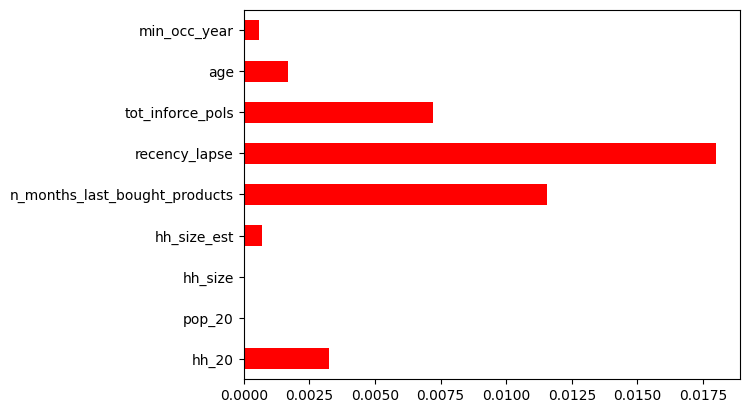

<Figure size 640x480 with 0 Axes>

In [28]:
from sklearn.feature_selection import mutual_info_classif
%matplotlib inline

importances = mutual_info_classif(X_train_num, y_train)
feat_importances = pd.Series(importances, X_train_num.columns[0:len(X_train_num.columns) ])
feat_importances.plot(kind = "barh", color = "red")
plt.show()
plt.tight_layout()

In [29]:
# top 5 highest information gains
highest_info_gain_columns = ['recency_lapse', 'n_months_last_bought_products', 'tot_inforce_pols', 'hh_size_est', 'hh_20']

# subset X_train_cat with the top 5 columns that have highest information gains
X_train_num[highest_info_gain_columns]

,recency_lapse,n_months_last_bought_products,tot_inforce_pols,hh_size_est,hh_20
10077,114.000000,5,1,4,125.0
18098,76.796162,14,1,3,58.0
5930,76.796162,8,3,2,83.5
3703,111.000000,24,3,1,109.0
17789,146.000000,7,4,3,79.0
...,...,...,...,...,...
13829,76.796162,164,1,5,1.0
18876,118.000000,91,1,2,8.0
5860,99.000000,99,1,5,137.0
17378,9.000000,8,8,3,27.0


### Chi-square test (categorical variables)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns


def prepare_inputs(X_train_pca, X_test_pca):
    oe = OrdinalEncoder()
    oe.fit(X_train_pca)
    X_train_enc = oe.transform(X_train_pca)
    X_test_enc = oe.transform(X_test_pca)
    return X_train_enc, X_test_enc

def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train_cat, X_test_cat)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

def select_features(X_train_pca, y_train, X_test_pca, k_value='all'):
    fs = SelectKBest(score_func=chi2, k=k_value)
    fs.fit(X_train_pca, y_train)
    X_train_fs = fs.transform(X_train_pca)
    X_test_fs = fs.transform(X_test_pca)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
'''for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))'''

for i in range(len(fs.scores_)):
    print(f'Feature {i}: Chi-Square Score = {fs.scores_[i]}, p-value = {fs.pvalues_[i]}')

alpha = 0.05
significant_features_indices = [i for i, p_value in enumerate(fs.pvalues_) if p_value < alpha] # extracting features with p value < 0.05
print(significant_features_indices)



Feature 0: Chi-Square Score = 39.401302930477335, p-value = 3.450666474405654e-10
Feature 1: Chi-Square Score = 1.6075299209895952, p-value = 0.20483936693918547
Feature 2: Chi-Square Score = 5.768610389284755, p-value = 0.016314930457056478
Feature 3: Chi-Square Score = 19.5690938147336, p-value = 9.702614310867037e-06
Feature 4: Chi-Square Score = 85.9127845046945, p-value = 1.880491056140756e-20
Feature 5: Chi-Square Score = 7.7123677755318445, p-value = 0.005484376906901335
Feature 6: Chi-Square Score = 287.607209771652, p-value = 1.6516992706875806e-64
Feature 7: Chi-Square Score = 5.358783530176623, p-value = 0.02061815093427465
Feature 8: Chi-Square Score = 0.7691398896334333, p-value = 0.3804832659241906
Feature 9: Chi-Square Score = 9.872477555985657, p-value = 0.0016776944230202945
Feature 10: Chi-Square Score = 66.7022210074641, p-value = 3.1577911217617614e-16
Feature 11: Chi-Square Score = 5.208838692164858, p-value = 0.02247234025680865
Feature 12: Chi-Square Score = 3.91

In [31]:
X_test_fs# Extract only the columns corresponding to significant features
X_test_fs_selected = X_test_fs[:, significant_features_indices]

# Now X_test_fs_selected contains only the columns corresponding to significant features
print(X_test_fs_selected)
len(X_test_fs_selected[0])

[[4. 2. 0. ... 1. 0. 0.]
 [0. 2. 0. ... 1. 0. 0.]
 [3. 2. 0. ... 1. 0. 0.]
 ...
 [0. 2. 0. ... 1. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [4. 2. 0. ... 1. 0. 0.]]


22

In [32]:
#Just to check the chi square score for each feature

# Prepare a list of tuples with feature index, Chi-square score, and p-value
feature_info = [(i, fs.scores_[i], fs.pvalues_[i]) for i in range(len(fs.scores_))]

# Filter features with p-value below alpha
significant_features_info = [(i, score, p_value) for i, score, p_value in feature_info if p_value < alpha]

# Sort the list by Chi-square score in descending order
significant_features_info.sort(key=lambda x: x[1], reverse=True)

# Extract the indices of significant features
sorted_significant_features_indices = [i for i, _, _ in significant_features_info]

# Subset the original_data with the selected indices
X_train_fs_selected = X_train_fs[:, sorted_significant_features_indices]

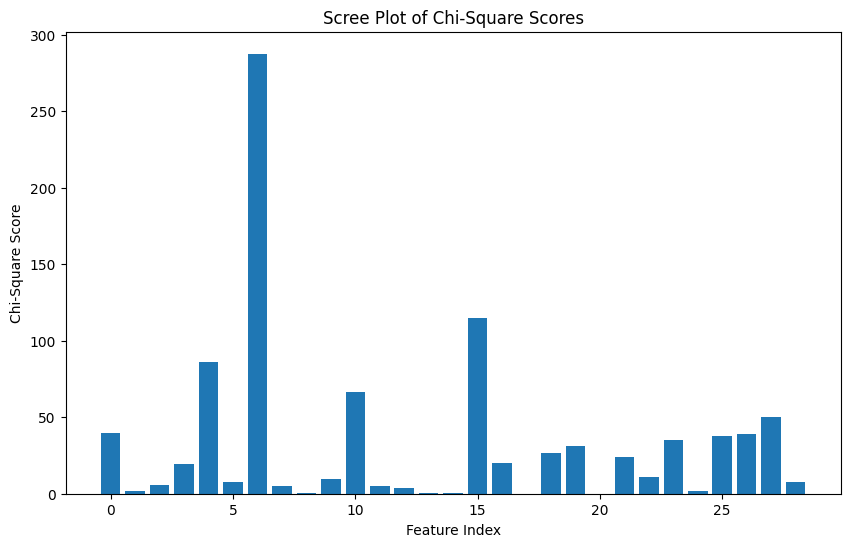

In [33]:
# Scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(fs.scores_)), fs.scores_)
plt.xlabel('Feature Index')
plt.ylabel('Chi-Square Score')
plt.title('Scree Plot of Chi-Square Scores')
plt.show()

In [34]:
X_train_combined = np.concatenate((X_train_selected_numerical, X_train_fs_selected), axis=1)
X_test_combined = np.concatenate((X_test_selected_numerical, X_test_fs_selected), axis=1)

## Handling Imbalanced Data

0.0    13637
1.0      594
Name: f_purchase_lh, dtype: int64
% of dataset where target = 1: 4.2%


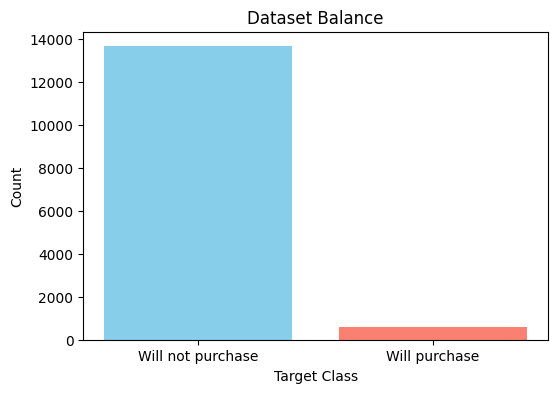

In [35]:
# Calculate dataset balance
print(y_train.value_counts())  # Imbalanced client target variable (0: will not purchase life or health insurance products within the next three months, 1: will purchase life or health insurance products within the next three months)
balance = y_train[y_train == 1].shape[0] / y_train.shape[0]
print("% of dataset where target = 1:", str(round(balance * 100, 1)) + "%")

# Visualize dataset balance
plt.figure(figsize=(6, 4))
plt.bar(['Will not purchase', 'Will purchase'], y_train.value_counts(), color=['skyblue', 'salmon'])
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Dataset Balance')
plt.show()


In [36]:
# Sampling to rebalance dataset

# SMOTE: Synthetic minority oversampling technique on fraud to create synthetic samples on training data
X_train_combined, y_train = SMOTE().fit_resample(X_train_combined, y_train) 

print(X_train_combined.shape)
print(X_test.shape)

(27274, 27)
(3558, 52)


% of dataset where target=1: 50.0%


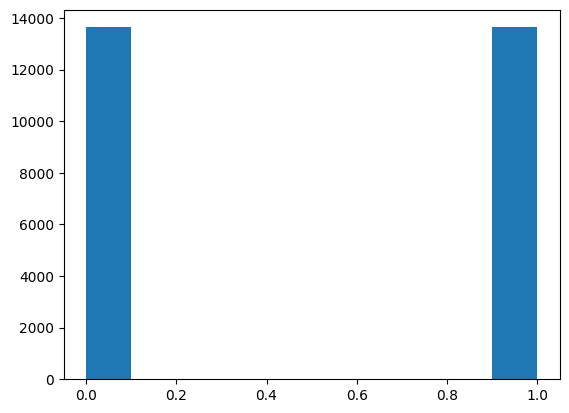

In [37]:
# Recalculate dataset balance
balance = y_train[y_train == 1].shape[0] / y_train.shape[0]
print("% of dataset where target=1:", str(round(balance * 100, 1)) + "%")

plt.hist(y_train)
plt.show()

## AI/ML Algorithms & Evaluation Matrices

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

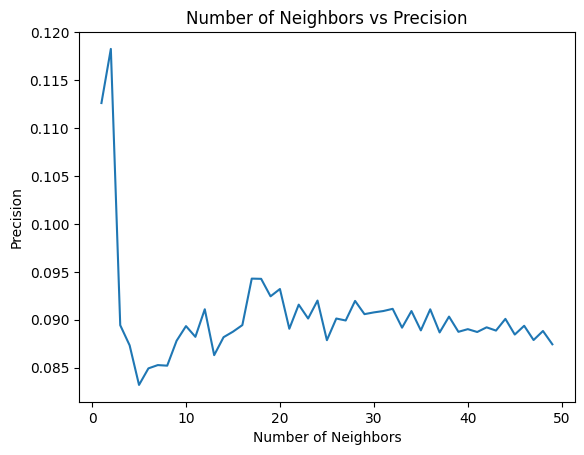

In [38]:
# Find elbow for knn

error = []
k = range(1, 50)
for i in k:
    print(i, end=" ")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_combined, y_train)
    y_pred = knn.predict(X_test_combined)
    y_pred = np.round(y_pred)
    error.append(metrics.f1_score(y_test, y_pred))
plt.plot(k, error)
plt.title('Number of Neighbors vs Precision')
plt.xlabel('Number of Neighbors')
plt.ylabel('Precision')
plt.show()

In [39]:
models = [
    ['KNN', KNeighborsClassifier(n_neighbors=12)], # from elbow method above
    ['DT', DecisionTreeClassifier(random_state=42)],
    ['NB', GaussianNB()],
    ['RF', RandomForestClassifier(n_estimators=X_train.shape[1], max_depth=None, min_samples_split=2, random_state=42)],
    ['MLP', MLPClassifier(random_state=42, max_iter=350)],
    ['AB', AdaBoostClassifier(n_estimators=X_train.shape[1], random_state=42)],
    ['LR', LogisticRegression(random_state=42)],
    ['SGD', SGDClassifier(loss="hinge", penalty="l2", max_iter=500)],
    ['HGB', HistGradientBoostingClassifier()],
    ['LGB', LGBMClassifier()],
    ['XGB', xgb.XGBClassifier(objective="binary:logistic", random_state=42)],
    ['QDA', QuadraticDiscriminantAnalysis()]
]

# Evaluation Matrices

In [40]:
# Dictionary that stores evaluation metrics of models
'''
Key: Model name
Value: A list containing the following metrics:
  - True Positive Rate
  - False Positive Rate
  - True Negative Rate
  - False Negative Rate
  - F1 Score
  - ROC AUC Score
  - Precision Score
'''
model_results = {}

In [46]:
# Function to view classification report
def clf_report(model_name, y_pred):
  '''
  Prints the classification report of a model.

  Inputs:
    model_name: name of the model 
    y_pred: a tensor/array of n binary prediction values of shape (n, 1)
  '''
  print(model_name)
  print(metrics.classification_report(y_test, y_pred, labels=[0, 1]))
  print("ROC AUC score:", round(metrics.roc_auc_score(y_test, y_pred), 2))
  print("F1 score:", round(metrics.f1_score(y_test, y_pred), 2))
  print("Accuracy score:", round(metrics.accuracy_score(y_test, y_pred), 2))
  matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
  tn, fp, fn, tp = matrix.ravel()
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  tnr = tn / (tn + fp)
  fnr = fn / (fn + tp)
  print("TPR: {:.2f} \nFPR: {:.2f} \nTNR: {:.2f} \nFNR: {:.2f}".format(tpr, fpr, tnr, fnr))

  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=[0, 1])
  disp.plot()
  plt.show()

  model_results[model_name] = [
      tpr, fpr, tnr, fnr, 
      metrics.f1_score(y_test, y_pred), 
      metrics.roc_auc_score(y_test, y_pred),
      metrics.precision_score(y_test, y_pred),
      metrics.accuracy_score(y_test, y_pred)
  ]

KNN
              precision    recall  f1-score   support

           0       0.98      0.63      0.76      3442
           1       0.05      0.58      0.09       116

    accuracy                           0.62      3558
   macro avg       0.51      0.60      0.43      3558
weighted avg       0.95      0.62      0.74      3558

ROC AUC score: 0.6
F1 score: 0.09
Accuracy score: 0.62
TPR: 0.58 
FPR: 0.37 
TNR: 0.63 
FNR: 0.42


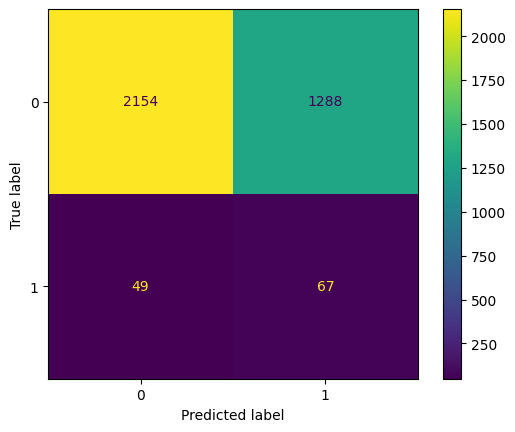


DT
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3442
           1       0.03      0.03      0.03       116

    accuracy                           0.94      3558
   macro avg       0.50      0.50      0.50      3558
weighted avg       0.94      0.94      0.94      3558

ROC AUC score: 0.5
F1 score: 0.03
Accuracy score: 0.94
TPR: 0.03 
FPR: 0.03 
TNR: 0.97 
FNR: 0.97


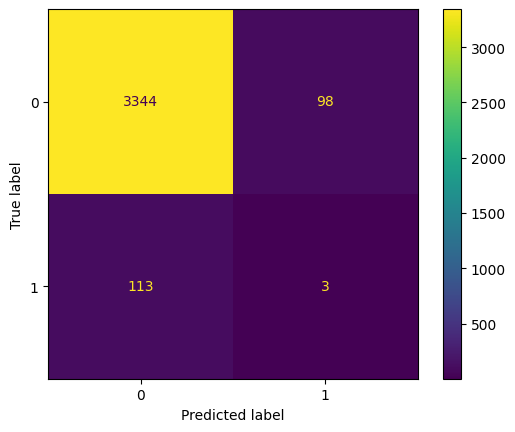


NB
              precision    recall  f1-score   support

           0       0.97      0.54      0.70      3442
           1       0.04      0.55      0.07       116

    accuracy                           0.54      3558
   macro avg       0.51      0.55      0.38      3558
weighted avg       0.94      0.54      0.68      3558

ROC AUC score: 0.55
F1 score: 0.07
Accuracy score: 0.54
TPR: 0.55 
FPR: 0.46 
TNR: 0.54 
FNR: 0.45


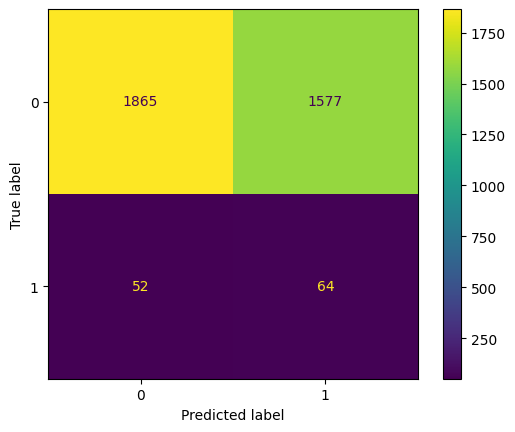


RF
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3442
           1       0.00      0.00      0.00       116

    accuracy                           0.97      3558
   macro avg       0.48      0.50      0.49      3558
weighted avg       0.94      0.97      0.95      3558

ROC AUC score: 0.5
F1 score: 0.0
Accuracy score: 0.97
TPR: 0.00 
FPR: 0.00 
TNR: 1.00 
FNR: 1.00
/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

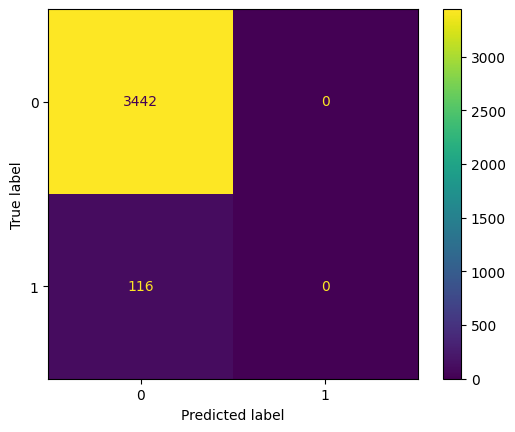

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3442
           1       0.00      0.00      0.00       116

    accuracy                           0.97      3558
   macro avg       0.48      0.50      0.49      3558
weighted avg       0.94      0.97      0.95      3558

ROC AUC score: 0.5
F1 score: 0.0
Accuracy score: 0.97
TPR: 0.00 
FPR: 0.00 
TNR: 1.00 
FNR: 1.00


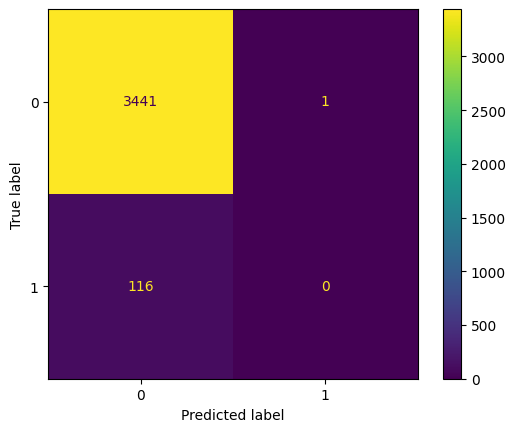


AB
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3442
           1       0.00      0.00      0.00       116

    accuracy                           0.97      3558
   macro avg       0.48      0.50      0.49      3558
weighted avg       0.94      0.97      0.95      3558

ROC AUC score: 0.5
F1 score: 0.0
Accuracy score: 0.97
TPR: 0.00 
FPR: 0.00 
TNR: 1.00 
FNR: 1.00
/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

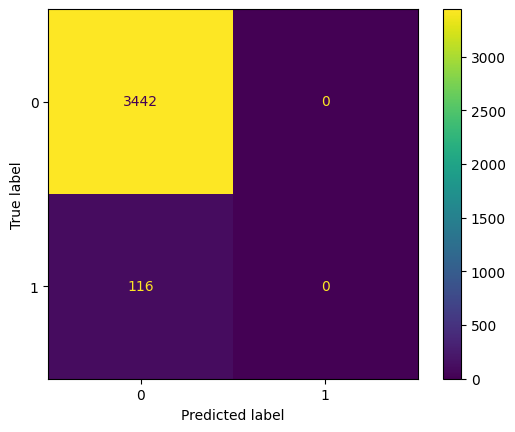

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LR
              precision    recall  f1-score   support

           0       0.97      0.58      0.73      3442
           1       0.04      0.49      0.07       116

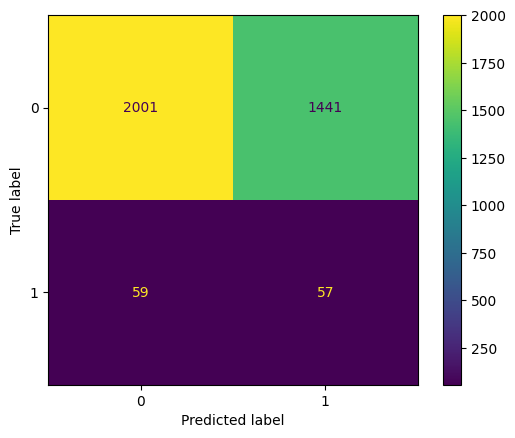


SGD
              precision    recall  f1-score   support

           0       0.97      0.66      0.79      3442
           1       0.03      0.34      0.06       116

    accuracy                           0.65      3558
   macro avg       0.50      0.50      0.42      3558
weighted avg       0.94      0.65      0.76      3558

ROC AUC score: 0.5
F1 score: 0.06
Accuracy score: 0.65
TPR: 0.34 
FPR: 0.34 
TNR: 0.66 
FNR: 0.66


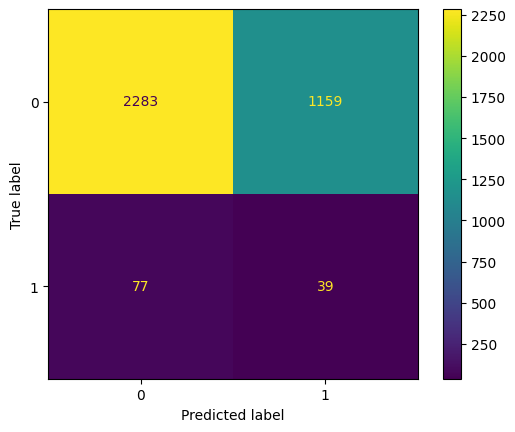


HGB
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3442
           1       0.04      0.01      0.01       116

    accuracy                           0.96      3558
   macro avg       0.50      0.50      0.50      3558
weighted avg       0.94      0.96      0.95      3558

ROC AUC score: 0.5
F1 score: 0.01
Accuracy score: 0.96
TPR: 0.01 
FPR: 0.01 
TNR: 0.99 
FNR: 0.99


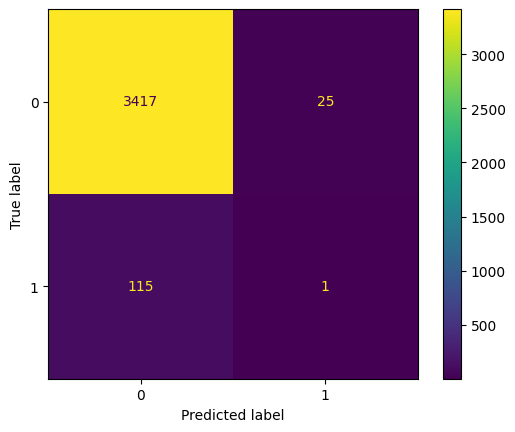


[LightGBM] [Info] Number of positive: 13637, number of negative: 13637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5639
[LightGBM] [Info] Number of data points in the train set: 27274, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGB
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3442
           1       0.15      0.02      0.03       116

    accuracy                           0.96      3558
   macro avg       0.56      0.51      0.51      3558
weighted avg       0.94      0.96      0.95      3558

ROC AUC score: 0.51
F1 score: 0.03
Accuracy score: 0.96
TPR: 0.02 
FPR: 0.00 
TNR: 1.00 
FNR: 0.98


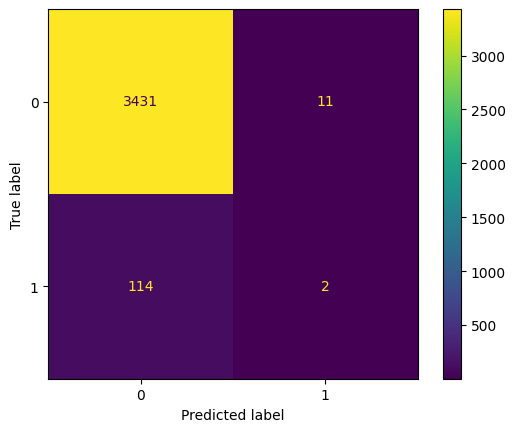


XGB
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3442
           1       0.17      0.03      0.06       116

    accuracy                           0.96      3558
   macro avg       0.57      0.51      0.52      3558
weighted avg       0.94      0.96      0.95      3558

ROC AUC score: 0.51
F1 score: 0.06
Accuracy score: 0.96
TPR: 0.03 
FPR: 0.01 
TNR: 0.99 
FNR: 0.97


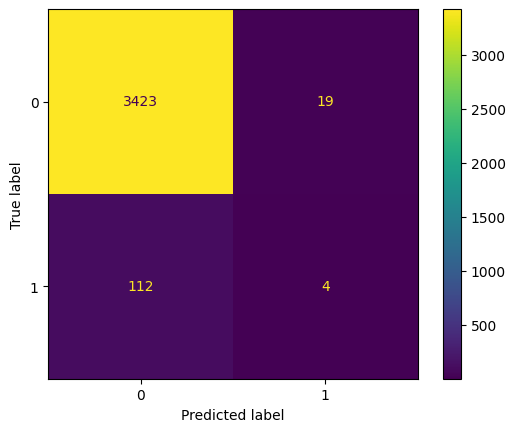


QDA
              precision    recall  f1-score   support

           0       0.97      0.75      0.84      3442
           1       0.04      0.29      0.07       116

    accuracy                           0.73      3558
   macro avg       0.50      0.52      0.46      3558
weighted avg       0.94      0.73      0.82      3558

ROC AUC score: 0.52
F1 score: 0.07
Accuracy score: 0.73
TPR: 0.29 
FPR: 0.25 
TNR: 0.75 
FNR: 0.71


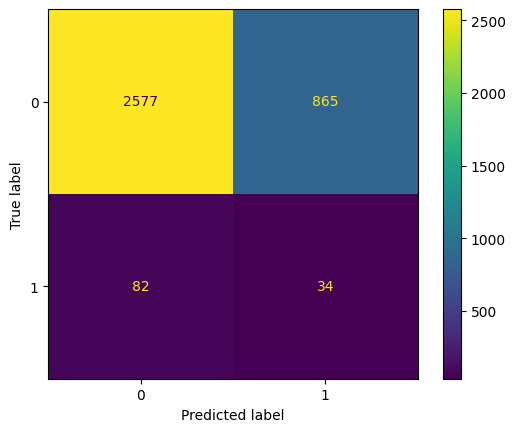

In [47]:
# Testing the models
for name, model in models:
  model.fit(X_train_combined, y_train)
  y_pred = model.predict(X_test_combined)
  y_pred = np.round(y_pred)
  # print prediction results for each model
  print("Predictions:", y_pred)

  # Classification Report
  clf_report(name, y_pred)
  print()

  # Separator
  print(''.join(['='] * 60))
  print(''.join(['='] * 60))

In [48]:
results_df = pd.DataFrame(model_results.values(), model_results.keys(), \
              ['TPR', 'FPR', 'TNR', 'FNR', 'F1 Score', 'ROC AUC Score', 'Precision'])

results_df

,TPR,FPR,TNR,FNR,F1 Score,ROC AUC Score,Precision
KNN,0.017241,0.001162,0.998838,0.982759,0.032787,0.508040,0.333333
DT,0.258621,0.102557,0.897443,0.741379,0.120240,0.578032,0.078329
NB,0.586207,0.492446,0.507554,0.413793,0.072379,0.546880,0.038571
RF,0.000000,0.000000,1.000000,1.000000,0.000000,0.500000,0.000000
MLP,0.025862,0.005520,0.994480,0.974138,0.043478,0.510171,0.136364
AB,0.008621,0.000581,0.999419,0.991379,0.016807,0.504020,0.333333
LR,0.603448,0.275421,0.724579,0.396552,0.123457,0.664014,0.068762
SGD,0.000000,0.001743,0.998257,1.000000,0.000000,0.499128,0.000000
HGB,0.008621,0.000581,0.999419,0.991379,0.016807,0.504020,0.333333
LGB,0.034483,0.005811,0.994189,0.965517,0.057143,0.514336,0.166667


ValueError: 7 columns passed, passed data had 8 columns

In [ ]:
best_roc, roc_key = 0, None
best_f1, f1_key = 0, None
best_tpr, tpr_key = 0, None
best_fpr, fpr_key = 1, None

for k, (tpr, fpr, tnr, fnr, f1, roc, prec) in model_results.items():
    if roc > best_roc:
        best_roc, roc_key = roc, k
    if f1 > best_f1:
        best_f1, f1_key = f1, k
    if tpr > best_tpr:
        best_tpr, tpr_key = tpr, k
    if fpr < best_fpr:
        best_fpr, fpr_key = fpr, k

print(f"Best ROC ({best_roc:.2f}) achieved by {roc_key}")
print(f"Best F1-score ({best_f1:.2f}) achieved by {f1_key}")
print(f"Best True Positive Rate ({best_tpr:.2f}) achieved by {tpr_key}")
print(f"Lowest False Positive Rate ({best_fpr:.2f}) achieved by {fpr_key}")

Best ROC (0.66) achieved by LR
Best F1-score (0.12) achieved by LR
Best True Positive Rate (0.60) achieved by LR
Lowest False Positive Rate (0.00) achieved by RF


In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
  
    result = [] 
    return result

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e3db2a45-faba-4225-911f-00205ccd2859' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>